In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
import numpy as np
from pandas import DataFrame
import pandas as pd
import re
from notebook_utils import NotebookUtilities
from datetime import timedelta
import matplotlib.pyplot as plt
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))


# OSU dataset of Simulation Sessions, deidentified

Doug screened all of the **VOICE_COMMAND** and **VOICE_CAPTURE** lines and replaced any names with either Max or Jane, regardless of whether the name was that of the responder.

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('clean_csvs_df'):
    clean_csvs_df = nu.load_object('clean_csvs_df')
    print(clean_csvs_df.shape)
    df = clean_csvs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 100)


,140814,101650,44858,102046
action_type,TOOL_HOVER,TOOL_HOVER,PULSE_TAKEN,TOOL_DISCARDED
action_tick,624225,865743,79294,892550
event_time,2023-04-21 10:17:00,2023-06-12 14:44:00,2023-03-03 11:37:00,2023-06-12 14:44:00
session_uuid,cf953248-e6cf-4544-95ce-4843d0f56f10,a0987257-801e-44c5-a1ad-81e0083bfa46,5dce5abe-7ded-46e7-8d07-b2e2cd76ef55,a0987257-801e-44c5-a1ad-81e0083bfa46
file_name,max16,a0987257-801e-44c5-a1ad-81e0083bfa46,Marty5,a0987257-801e-44c5-a1ad-81e0083bfa46
scene_index,2,3,1,3
pulse_taken_pulse_name,NaN,NaN,pulse_faint,NaN
pulse_taken_patient_id,NaN,NaN,Mike_3 Root,NaN
tool_hover_type,Gauze,Gauze,NaN,NaN
tool_hover_count,1000,1000,NaN,NaN



## Decision Points

<p>
    OSU and Big Bear: With the IRB approval (for the previous OSU dataset) in place, I would like to get working on the dataset asap. That means:
    <ul>
        <li>Getting it deidentified and sharable</li>
        <li>If there is general demographic information like gender or level of expertise that can be associated with the VR performance, that would be useful.</li>
        <li>Big Bear: once it is available to you, I want an exploratory analysis on decision points such that I can see the variance in responses to the same situation.</li>
        <li>For example, if there are 3 waving patients and the participant chooses to move toward one and assess them, I want to know the sim state (visual info. on each patient, distance, etc.) and then a breakdown of how many participants chose to move toward each patient.</li>
        <li>Similar for treatment options, for each patient present in the simulated environment, what is the variance in which treatment is applied</li>
         <li>Does it depend on ordr?</li>
          <li>Ting?</li>
           <li>Be creative and ask all the questions. The goal is to provide TA1 with this dataset if there is anything useful to be found in analyzing the decisions (not necessarily that we find results but that the data is in shape to ask these questions). Let me know if you need additional clarifiion   </l    i>
</</p>
ion.

In [4]:

# List the action types
clean_csvs_df.action_type.value_counts().sort_index()

action_type
BAG_ACCESS              2180
BAG_CLOSED              2149
INJURY_RECORD           3052
INJURY_TREATED          1577
PATIENT_DEMOTED         1818
PATIENT_ENGAGED         2295
PATIENT_RECORD          2063
PULSE_TAKEN             3427
SESSION_END              256
SESSION_START            266
S_A_L_T_WALKED          2725
S_A_L_T_WALK_IF_CAN     4567
S_A_L_T_WAVED           1761
S_A_L_T_WAVE_IF_CAN     2147
TAG_APPLIED             1819
TAG_DISCARDED            533
TAG_SELECTED            2353
TELEPORT                5678
TOOL_APPLIED            1818
TOOL_DISCARDED          1655
TOOL_HOVER             89733
TOOL_SELECTED           2263
VOICE_CAPTURE          10115
VOICE_COMMAND           2916
Name: count, dtype: int64

In [9]:

# Store a dataset of DM actions as a CSV
columns_list = [
    'session_uuid', 'action_type', 'action_tick', 'event_time', 'tag_applied_type', 'tool_applied_type', 'injury_treated_id',
    'patient_id', 'location_id', 'scene_index'
]
patient_engagement_timeline_df = pd.DataFrame()
for session_uuid, session_df in fu.get_session_groupby():
    mask_series = session_df.action_type.isin(['SESSION_END', 'SESSION_START'])
    patient_engagement_timeline_df = pd.concat(
        [patient_engagement_timeline_df, session_df[mask_series][columns_list].dropna(axis='columns', how='all')], axis='index'
    )
    mask_series = clean_csvs_df.action_type.isin([
        'INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
    ])
    for patient_id, patient_df in session_df[mask_series][columns_list].groupby('patient_id'):
        patient_engagement_timeline_df = pd.concat(
            [patient_engagement_timeline_df, patient_df.dropna(axis='columns', how='all')], axis='index'
        )
patient_engagement_timeline_df = patient_engagement_timeline_df.sort_values(['session_uuid', 'event_time', 'action_tick'])
nu.save_dataframes(patient_engagement_timeline_df=patient_engagement_timeline_df)

Saving to C:\Users\DaveBabbitt\Documents\GitHub\notebooks\saves\csv\patient_engagement_timeline_df.csv


In [8]:

clean_csvs_df.loc[51217].dropna(axis='index', how='all').to_frame()

,51217
action_type,TAG_APPLIED
action_tick,281683
event_time,2023-06-07 10:30:00
session_uuid,04882754-51a0-4e5b-9617-b200e3609116
file_name,04882754-51a0-4e5b-9617-b200e3609116
scene_index,2
tag_applied_patient_id,Gary_3 Root
tag_applied_type,red
patient_id,Gary_3 Root



### Patient Engagement


These action types mean that the DM has made a decision: INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, and TOOL_APPLIED.


#### Record the decision points on each patient's timeline in a Patient Engagement timeline CSV

In [22]:

mask_series = clean_csvs_df.action_type.isin(['PATIENT_ENGAGED'])
# columns_list = clean_csvs_df[mask_series].dropna(axis='columns', how='all').columns.tolist()
columns_list = [
    'action_tick', 'patient_engaged_health_level', 'patient_engaged_health_time_remaining', 'patient_engaged_id',
    'patient_engaged_position', 'patient_engaged_rotation', 'patient_engaged_salt', 'patient_engaged_sort', 'patient_engaged_pulse',
    'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose'
]
clean_csvs_df[mask_series][columns_list]

,action_tick,patient_engaged_health_level,patient_engaged_health_time_remaining,patient_engaged_id,patient_engaged_position,patient_engaged_rotation,patient_engaged_salt,patient_engaged_sort,patient_engaged_pulse,patient_engaged_breath,patient_engaged_hearing,patient_engaged_mood,patient_engaged_pose
49,91120,100,128,Mike_3 Root,"(3.1, 0.0, 4.4)","(0.0, 0.7, 0.0, -0.7)",IMMEDIATE,still,faint,collapsedRight,normal,unresponsive,supine
164,176515,100,Infinity,Mike_1 Root,"(2.9, 0.0, 0.1)","(0.0, 0.7, 0.0, -0.7)",DELAYED,waver,normal,normal,normal,upset,recovery
304,259247,100,Infinity,Mike_0 Root,"(1.4, 0.0, -3.1)","(0.0, 0.1, 0.0, 1.0)",MINIMAL,walker,normal,normal,normal,upset,standing
338,295168,100,Infinity,Mike_2 Root,"(2.9, 0.0, -5.1)","(0.0, 0.1, 0.0, -1.0)",IMMEDIATE,walker,fast,normal,normal,upset,standing
410,343840,100,Infinity,Mike_0 Root,"(1.4, 0.0, -3.1)","(0.0, 0.1, 0.0, 1.0)",MINIMAL,walker,normal,normal,normal,upset,standing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148963,365374,100,Infinity,Lily_2 Root,"(3.0, 0.0, 4.5)","(0.0, 1.0, 0.0, 0.0)",IMMEDIATE,waver,fast,fast,normal,agony,fetal
149029,380448,100,Infinity,Mike_5 Root,"(2.7, 0.0, 2.3)","(0.0, 1.0, 0.0, 0.0)",IMMEDIATE,waver,fast,normal,normal,upset,fetal
149100,425329,100,0,Gary_9 Root,"(3.0, 0.0, 9.1)","(0.0, 1.0, 0.0, 0.0)",MINIMAL,walker,normal,normal,limited,calm,standing
149106,439695,100,Infinity,Gloria_8 Root,"(4.4, 0.0, -1.4)","(0.0, -0.2, 0.0, -1.0)",MINIMAL,walker,normal,normal,normal,upset,standing



#### Visualize the decision points on each patient's timeline

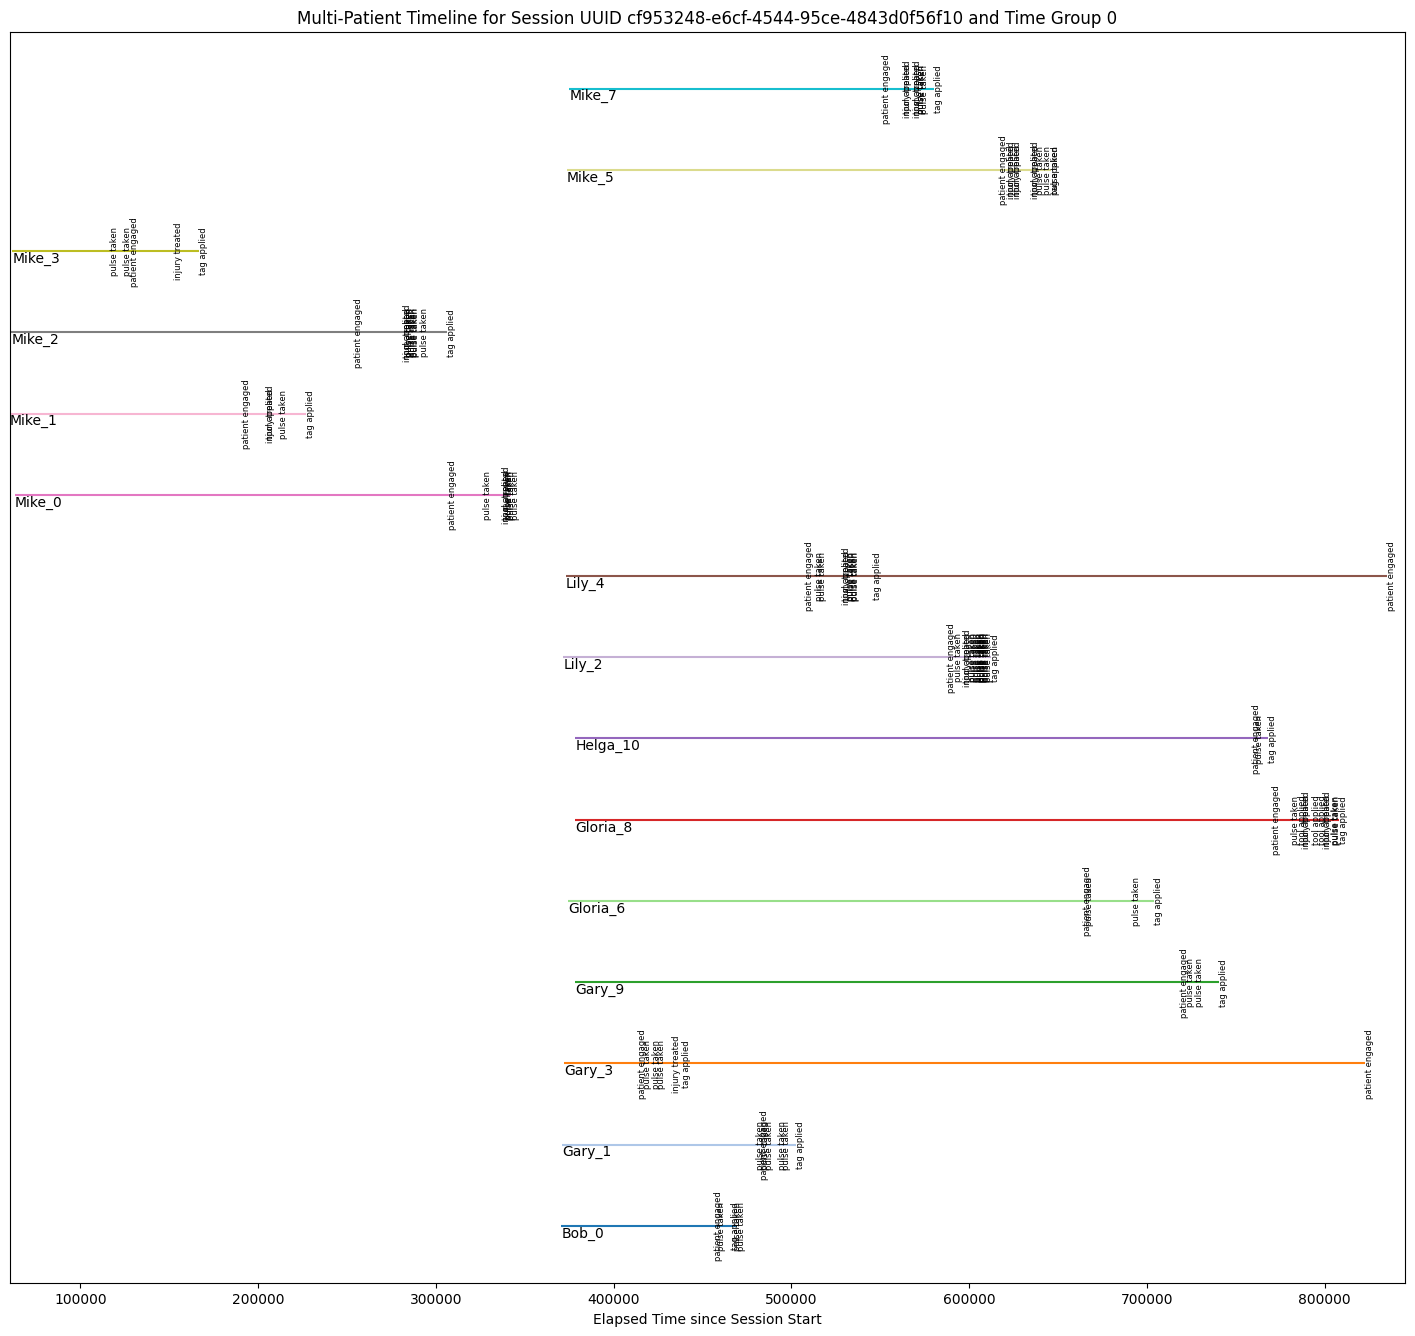

In [192]:

random_session_uuid, random_time_group, gary_df = fu.show_timelines(frvrs_logs_df=frvrs_logs_df)


When the *PATIENT_DEMOTED* type action happens, it means only that the status of a patient has changed. This happens when the scene first loads and the initial patient status is calculated. Over time, if the patient is not attended to, the status will degrade and the PATIENT_DEMOTED metric is issued.

In [193]:

# Display the captured timeline (Gary_3's)
mask_series = gary_df.action_type.isin([
    'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
])
action_tick = gary_df[mask_series].action_tick.min()
event_time = gary_df[mask_series].event_time.min()
mask_series = (clean_csvs_df.session_uuid == random_session_uuid) & (clean_csvs_df.scene_index == random_time_group)
mask_series &= (clean_csvs_df.action_tick <= action_tick) & (clean_csvs_df.event_time <= event_time)
columns_list = [
    'action_type', 'action_tick', 'event_time', 'voice_capture_message', 'voice_command_message', 'patient_demoted_salt',
    'patient_id', 'location_id'
]
display(clean_csvs_df[mask_series][columns_list].head(20).dropna(axis='columns', how='all'))

,action_type,action_tick,event_time,voice_capture_message,patient_demoted_salt,patient_id,location_id
138481,TELEPORT,2372,2023-04-21 10:06:00,NaN,NaN,NaN,"(2.4, 0.0, 2.1)"
138482,VOICE_CAPTURE,4261,2023-04-21 10:06:00,Yeah,NaN,NaN,NaN
138483,TELEPORT,4895,2023-04-21 10:06:00,NaN,NaN,NaN,"(2.0, 0.0, 1.7)"
138484,VOICE_CAPTURE,6599,2023-04-21 10:06:00,yeah,NaN,NaN,NaN
138485,VOICE_CAPTURE,9455,2023-04-21 10:06:00,so it turns green OK,NaN,NaN,NaN
138486,VOICE_CAPTURE,13213,2023-04-21 10:06:00,well put it like teleport yeah,NaN,NaN,NaN
138487,VOICE_CAPTURE,21616,2023-04-21 10:07:00,right here,NaN,NaN,NaN
138488,BAG_ACCESS,24023,2023-04-21 10:07:00,NaN,NaN,NaN,"(3.1, 0.8, 10.6)"
138489,VOICE_CAPTURE,25257,2023-04-21 10:07:00,index finger on the trigger,NaN,NaN,NaN
138490,VOICE_CAPTURE,28384,2023-04-21 10:07:00,oh right here,NaN,NaN,NaN



### Affinity Analysis and Association Rule Learning using the Apriori Algorithm

In [4]:

# Record as transactions a more complex example of a patient engagement
if nu.pickle_exists('patient_engagement_transactions'):
    patient_engagement_transactions = nu.load_object('patient_engagement_transactions')
else:
    patient_engagement_transactions = []
    mask_series = (clean_csvs_df.action_type == 'PATIENT_ENGAGED')
    for (session_uuid, patient_id), patient_df in fu.get_session_groupby(
        mask_series=mask_series, extra_column='patient_id'
    ):
        for scene_index, scene_df in patient_df.groupby('scene_index'):
            mask_series = (clean_csvs_df.session_uuid == session_uuid) & (clean_csvs_df.scene_index == scene_index)
            action_tick = fu.get_scene_start(scene_df); mask_series &= (clean_csvs_df.action_tick <= action_tick)
            event_time = scene_df.event_time.min(); mask_series &= (clean_csvs_df.event_time <= event_time)
            action_types_list = clean_csvs_df[mask_series].tail(20).action_type.tolist()
            patient_engagement_transactions.append(action_types_list)
    nu.store_objects(patient_engagement_transactions=patient_engagement_transactions)

In [49]:

from apyori import apriori

apyori_rules_generator = apriori(
    patient_engagement_transactions, min_support=0.0022, min_confidence=0.20, min_lift=3, min_length = 4
)

# Store rules in result variable
if nu.pickle_exists('apyori_rules_list'):
    apyori_rules_list = nu.load_object('apyori_rules_list')
else:
    apyori_rules_list = list(apyori_rules_generator)
    nu.store_objects(apyori_rules_list=apyori_rules_list)

# See the items that were bought together with their support
results_list = []
for i in range(0, len(apyori_rules_list)):
    results_list.append('RULE:\t' + str(apyori_rules_list[i][0]) + '\nSUPPORT:\t' + str(apyori_rules_list[i][1]))
print(f'{len(results_list):,} rules')
print(results_list[0])

9,616 rules
RULE:	frozenset({'INJURY_RECORD', 'PATIENT_DEMOTED'})
SUPPORT:	0.007669616519174041


In [5]:

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert the list of lists to one hot
te = TransactionEncoder()
te_ary = te.fit(patient_engagement_transactions).transform(patient_engagement_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Build the model
itemsets_df = apriori(df, use_colnames=True)
print(f'{itemsets_df.shape[0]:,} rules')
itemsets_df.sort_values('support', ascending=False).head()

43 rules


,support,itemsets
1,1.000000,(PATIENT_ENGAGED)
4,0.909145,(TELEPORT)
14,0.909145,"(PATIENT_ENGAGED, TELEPORT)"
0,0.753982,(BAG_CLOSED)
7,0.753982,"(PATIENT_ENGAGED, BAG_CLOSED)"
